# Machine Learning in Python - MNIST Fashion

## Data Prep

### Lots of Imports

To build predictive models in Python we use a set of libraries that are imported here. In particular **pandas** and **sklearn** are particularly important.

In [1]:
import os
import subprocess
from IPython.display import display, HTML, Image
import io
from operator import itemgetter

from TAS_Python_Utilities import data_viz
from TAS_Python_Utilities import data_viz_target
from TAS_Python_Utilities import visualize_tree

import pandas as pd  # used
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from random import randint
from scipy.misc import toimage

from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn import neural_network

%matplotlib inline
#%qtconsole

### Setup - IMPORTANT

Take only a sample of the dataset for fast testing

In [2]:
data_sampling_rate = 0.1

Setup the number of folds for all grid searches (should be 5 - 10)

In [3]:
cv_folds = 2

Set up a dictionary to store simple model perofrmance comparions

In [4]:
model_test_accuracy_comparisons = dict()
model_valid_accuracy_comparisons = dict()
model_tuned_params_list = dict()

### Load & Partition Data

Load the dataset and explore it.

In [5]:
dataset = pd.read_csv('fashion-mnist_train.csv')
dataset = dataset.sample(frac=data_sampling_rate) #take a sample from the dataset so everyhting runs smoothly
num_classes = 10
classes = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}
display(dataset.head())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
9292,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7978,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40060,1,0,0,0,0,0,0,0,0,0,...,57,0,0,0,0,0,0,0,0,0
38941,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38790,2,0,0,0,0,0,0,0,17,48,...,0,0,0,0,0,66,0,0,0,0


Examine the distribution of the two classes

In [6]:
dataset["label"].value_counts()

3    649
4    632
6    613
0    612
8    594
7    591
2    588
1    584
5    581
9    556
Name: label, dtype: int64

In [7]:
if(dataset.select_dtypes(include=[np.number]).shape[1] > 0):
    display(dataset.select_dtypes(include=[np.number]).describe())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.00000,...,6000.000000,6000.000000,6000.000000,6000.00000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,4.451833,0.001333,0.003167,0.033667,0.089500,0.211333,0.278667,0.730500,2.254000,5.98600,...,35.811667,23.937333,17.067167,17.21650,22.329833,18.351167,8.977500,2.685000,0.878500,0.065500
std,2.845704,0.091285,0.123123,0.613131,1.606628,3.249990,4.095869,6.754935,14.373143,24.58641,...,58.406758,49.060863,42.315573,43.24293,51.264592,46.158039,31.021058,16.793842,9.575578,2.453544
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,60.000000,14.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,7.000000,7.000000,35.000000,83.000000,113.000000,205.000000,185.000000,219.000000,242.00000,...,255.000000,247.000000,250.000000,241.00000,242.000000,255.000000,237.000000,220.000000,199.000000,155.000000


In [8]:
# Check for presence of missing values
print("Missing Values")
print(dataset.isnull().sum())

Missing Values
label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
pixel5      0
pixel6      0
pixel7      0
pixel8      0
pixel9      0
pixel10     0
pixel11     0
pixel12     0
pixel13     0
pixel14     0
pixel15     0
pixel16     0
pixel17     0
pixel18     0
pixel19     0
pixel20     0
pixel21     0
pixel22     0
pixel23     0
pixel24     0
pixel25     0
pixel26     0
pixel27     0
pixel28     0
pixel29     0
           ..
pixel755    0
pixel756    0
pixel757    0
pixel758    0
pixel759    0
pixel760    0
pixel761    0
pixel762    0
pixel763    0
pixel764    0
pixel765    0
pixel766    0
pixel767    0
pixel768    0
pixel769    0
pixel770    0
pixel771    0
pixel772    0
pixel773    0
pixel774    0
pixel775    0
pixel776    0
pixel777    0
pixel778    0
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64


Isolate the descriptive features we are interested in

In [9]:
X = dataset[dataset.columns[1:]]
Y = np.array(dataset["label"])

In [10]:
len(X)

6000

Display some of the images

5084
[ 5084 ]  Bag


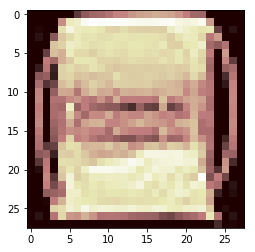

692
[ 692 ]  T-shirt/top


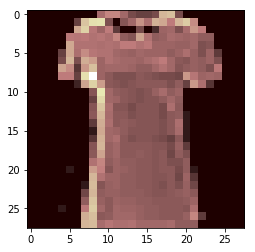

1024
[ 1024 ]  T-shirt/top


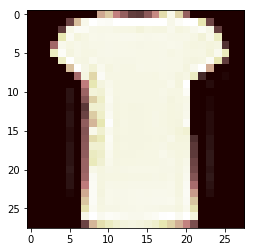

2073
[ 2073 ]  Dress


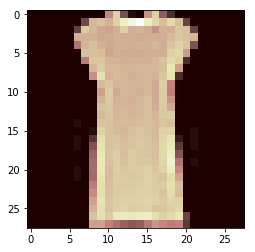

732
[ 732 ]  Shirt


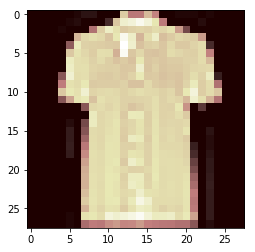

977
[ 977 ]  Sneaker


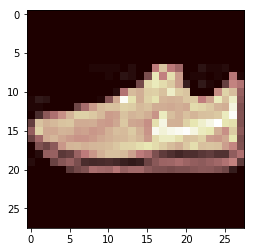

3042
[ 3042 ]  T-shirt/top


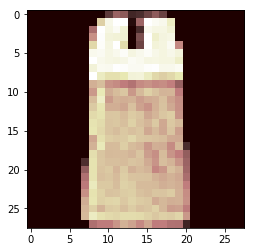

2253
[ 2253 ]  Sandal


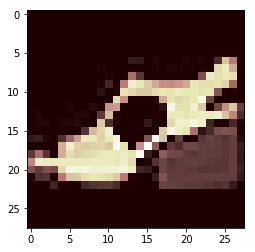

4168
[ 4168 ]  Ankle boot


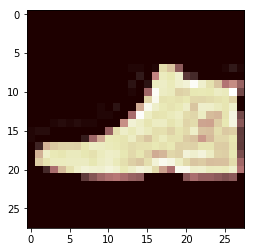

In [11]:
# create a sample of images from the dataset
for i in range(0, 9):
    i_rand = randint(0, X.shape[0])
    print(i_rand)                
    print("[", i_rand, "] ", classes[Y[i_rand]])
    two_d = (X.iloc[i_rand].values.reshape(28, 28))
    pyplot.imshow(two_d, cmap='pink')
    pyplot.show()


Normalise the data (important for some models)

In [12]:
X = X/255

Split the data into a **training set**, a **vaidation set**, and a **test set**

In [13]:
X_train_plus_valid, X_test, y_train_plus_valid, y_test \
    = train_test_split(X, Y, random_state=0, \
                                    train_size = 0.7)

X_train, X_valid, y_train, y_valid \
    = train_test_split(X_train_plus_valid, \
                                        y_train_plus_valid, \
                                        random_state=0, \
                                        train_size = 0.5/0.7)

## Building Simple Models

### A Very Simple Decision Tree

Train a decision tree

In [14]:
my_tree = tree.DecisionTreeClassifier(criterion="entropy")
my_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Visualise the decision tree so we can see what it is doing!

In [ ]:
#feature_names = list(X_train.columns)
#visualize_tree(my_tree, feature_names, fileName='dt_over.png')
#Image(filename='dt_over.png') 

### Evaluating Model Performance

Assess the performance of the decision tree on the training set

In [15]:
# Make a set of predictions for the training data
y_pred = my_tree.predict(X_train)

# Print performance details
accuracy = metrics.accuracy_score(y_train, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_train, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_train, y_pred))

# Print nicer homemade confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_train), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       299
          1       1.00      1.00      1.00       283
          2       1.00      1.00      1.00       285
          3       1.00      1.00      1.00       350
          4       1.00      1.00      1.00       305
          5       1.00      1.00      1.00       297
          6       1.00      1.00      1.00       295
          7       1.00      1.00      1.00       321
          8       1.00      1.00      1.00       288
          9       1.00      1.00      1.00       277

avg / total       1.00      1.00      1.00      3000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,299,0,0,0,0,0,0,0,0,0,299
1,0,283,0,0,0,0,0,0,0,0,283
2,0,0,285,0,0,0,0,0,0,0,285
3,0,0,0,350,0,0,0,0,0,0,350
4,0,0,0,0,305,0,0,0,0,0,305
5,0,0,0,0,0,297,0,0,0,0,297
6,0,0,0,0,0,0,295,0,0,0,295
7,0,0,0,0,0,0,0,321,0,0,321
8,0,0,0,0,0,0,0,0,288,0,288


Assess the performance of the tree on the validation dataset

In [16]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Simple Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_valid, y_pred))

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.716666666667
             precision    recall  f1-score   support

          0       0.70      0.69      0.69       124
          1       0.90      0.91      0.91       132
          2       0.56      0.59      0.58       112
          3       0.73      0.79      0.76       126
          4       0.61      0.59      0.60       120
          5       0.81      0.87      0.84       115
          6       0.43      0.42      0.42       129
          7       0.73      0.72      0.73       107
          8       0.88      0.84      0.86       122
          9       0.83      0.75      0.79       113

avg / total       0.72      0.72      0.72      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,85,1,4,5,3,0,25,0,1,0,124
1,0,120,0,9,1,0,2,0,0,0,132
2,4,0,66,4,23,0,12,0,3,0,112
3,3,4,3,100,6,1,9,0,0,0,126
4,0,3,17,13,71,0,15,0,1,0,120
5,0,1,0,0,0,100,2,5,2,5,115
6,28,3,22,6,12,0,54,0,4,0,129
7,0,0,0,0,0,16,0,77,2,12,107
8,2,0,5,0,1,4,7,0,102,1,122


Assess the performance of the tree on the validation dataset

In [17]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Simple Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_test, y_pred))

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.727222222222
             precision    recall  f1-score   support

          0       0.72      0.75      0.74       189
          1       0.93      0.93      0.93       169
          2       0.60      0.66      0.63       191
          3       0.69      0.80      0.74       173
          4       0.58      0.53      0.56       207
          5       0.81      0.76      0.79       169
          6       0.44      0.38      0.41       189
          7       0.79      0.88      0.83       163
          8       0.86      0.84      0.85       184
          9       0.91      0.83      0.86       166

avg / total       0.73      0.73      0.72      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,142,0,2,12,5,1,24,0,3,0,189
1,1,158,0,10,0,0,0,0,0,0,169
2,5,1,126,4,32,0,20,0,3,0,191
3,8,6,3,138,8,1,8,0,1,0,173
4,5,2,47,15,110,0,24,0,4,0,207
5,0,0,0,1,0,129,0,21,8,10,169
6,36,3,27,15,32,1,72,0,3,0,189
7,0,0,0,0,0,17,0,143,0,3,163
8,0,0,6,2,2,4,14,1,154,1,184


### Less Overiftted Decision Tree

Train a decision tree, setting min samples per leaf to a sensible value

In [18]:
my_tree = tree.DecisionTreeClassifier(criterion="entropy", min_samples_split = 200)
my_tree = my_tree.fit(X_train,y_train)

Visualise the decision tree so we can see what it is doing!

In [ ]:
# visualise the decision tree
#feature_names = list(X_train.columns)
#visualize_tree(my_tree, feature_names, fileName="dt_under.png")
#Image(filename='dt_under.png') 

Assess the performance of the decision tree on the **training set**

In [19]:
# Make a set of predictions for the training data
y_pred = my_tree.predict(X_train)

# Print performance details
accuracy = metrics.accuracy_score(y_train, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_train, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_train), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.759
             precision    recall  f1-score   support

          0       0.77      0.76      0.77       299
          1       0.96      0.84      0.90       283
          2       0.68      0.68      0.68       285
          3       0.62      0.89      0.73       350
          4       0.61      0.59      0.60       305
          5       0.87      0.85      0.86       297
          6       0.64      0.35      0.45       295
          7       0.82      0.85      0.83       321
          8       0.80      0.90      0.85       288
          9       0.91      0.85      0.88       277

avg / total       0.76      0.76      0.75      3000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,227,2,7,36,4,0,5,0,18,0,299
1,1,239,2,40,0,0,0,0,1,0,283
2,5,0,194,5,63,0,7,0,11,0,285
3,1,8,2,313,12,0,9,0,5,0,350
4,0,0,31,53,180,0,34,0,7,0,305
5,0,0,0,4,0,252,0,35,2,4,297
6,55,0,46,37,34,1,104,0,18,0,295
7,0,0,0,0,0,27,0,273,1,20,321
8,4,0,4,8,3,4,4,1,260,0,288


Assess the performance of the decision tree on the **validation set**

In [20]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Better Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True, dropna = False)

Accuracy: 0.691666666667
             precision    recall  f1-score   support

          0       0.73      0.77      0.75       124
          1       0.96      0.86      0.90       132
          2       0.55      0.59      0.57       112
          3       0.57      0.92      0.71       126
          4       0.50      0.49      0.50       120
          5       0.74      0.77      0.75       115
          6       0.55      0.26      0.35       129
          7       0.69      0.69      0.69       107
          8       0.80      0.81      0.81       122
          9       0.85      0.77      0.81       113

avg / total       0.70      0.69      0.68      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,95,0,2,14,5,0,5,0,3,0,124
1,0,113,2,17,0,0,0,0,0,0,132
2,1,1,66,2,34,0,5,0,3,0,112
3,0,1,1,116,3,1,2,0,2,0,126
4,0,1,18,22,59,0,14,0,6,0,120
5,0,1,0,5,0,88,0,14,3,4,115
6,31,1,26,19,13,0,33,0,6,0,129
7,0,0,0,0,0,23,0,74,0,10,107
8,3,0,6,5,3,4,1,0,99,1,122


In [21]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Better Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True, dropna = False)

Accuracy: 0.696666666667
             precision    recall  f1-score   support

          0       0.73      0.71      0.72       189
          1       0.98      0.87      0.92       169
          2       0.64      0.68      0.66       191
          3       0.50      0.86      0.63       173
          4       0.54      0.54      0.54       207
          5       0.78      0.72      0.74       169
          6       0.53      0.25      0.34       189
          7       0.76      0.83      0.79       163
          8       0.78      0.80      0.79       184
          9       0.90      0.78      0.84       166

avg / total       0.71      0.70      0.69      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,135,0,2,29,4,1,10,0,8,0,189
1,0,147,1,21,0,0,0,0,0,0,169
2,2,0,130,6,42,0,6,0,5,0,191
3,7,1,0,149,7,1,5,0,3,0,173
4,0,2,37,31,111,0,20,0,6,0,207
5,0,0,0,7,0,121,0,27,5,9,169
6,41,0,28,29,33,0,48,0,10,0,189
7,0,0,0,0,0,21,0,136,0,6,163
8,1,0,5,14,7,7,2,1,147,0,184


## Choosing Parameters Using a Grid Search

Use a cross validation to perfrom an evaluation

In [22]:
my_tree = tree.DecisionTreeClassifier(max_depth = 12)
scores = cross_val_score(my_tree, X_train_plus_valid, y_train_plus_valid, cv=10)
print(scores)

[ 0.72641509  0.75235849  0.76832151  0.72985782  0.74109264  0.73031026
  0.72966507  0.71223022  0.74278846  0.69711538]


An alternative to using post pruning explicitly is to use a grid search through a large set of possible parameters. Here we try depths between 3 and 20 and different limits on the minimum number of samples per split.

In [23]:
# Set up the parameter grid to seaerch
param_grid ={'criterion': ['gini', "entropy"], \
             'max_depth': list(range(3, 50, 3)), \
             'min_samples_split': [200]}

# Perform the search
my_tuned_tree = GridSearchCV(tree.DecisionTreeClassifier(), \
                                param_grid, cv=cv_folds, verbose = 2, \
                            return_train_score=True)
my_tuned_tree.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
display(my_tuned_tree.best_params_)
model_tuned_params_list["Tuned Tree"] = my_tuned_tree.best_params_
display(my_tuned_tree.best_score_)
display(my_tuned_tree.cv_results_)

Fitting 2 folds for each of 32 candidates, totalling 64 fits
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.2s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.2s
[CV] criterion=gini, max_depth=6, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=6, min_samples_split=200, total=   0.4s
[CV] criterion=gini, max_depth=6, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=6, min_samples_split=200, total=   0.4s
[CV] criterion=gini, max_depth=9, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=9, min_samples_split=200, total=   0.4s
[CV] criterion=gini, max_depth=9, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=9, min_samples_split=200, total=   0.4s
[CV] criterion=gini, max_depth=12, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=12, min_samples_split=200, total=   0.4s
[CV] criterion=gini, max_depth=12, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=12, min_samples_split=200, total=   0.4s
[CV] criterion=gini, max_depth=15, min_samples_split=200 ...........

[CV]  criterion=entropy, max_depth=42, min_samples_split=200, total=   0.9s
[CV] criterion=entropy, max_depth=42, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=42, min_samples_split=200, total=   0.8s
[CV] criterion=entropy, max_depth=45, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=45, min_samples_split=200, total=   0.8s
[CV] criterion=entropy, max_depth=45, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=45, min_samples_split=200, total=   0.8s
[CV] criterion=entropy, max_depth=48, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=48, min_samples_split=200, total=   0.8s
[CV] criterion=entropy, max_depth=48, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=48, min_samples_split=200, total=   0.8s


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   37.9s finished


Best parameters set found on development set:


{'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 200}

0.69214285714285717

{'mean_fit_time': array([ 0.21559262,  0.37969148,  0.36862409,  0.36399138,  0.40306544,
         0.37949491,  0.37313533,  0.36128604,  0.36533034,  0.37703013,
         0.39513099,  0.39191985,  0.41246796,  0.3892976 ,  0.41713798,
         0.41202414,  0.47022986,  0.86847246,  0.89315045,  0.88341177,
         0.84894884,  0.76232457,  0.755023  ,  0.75988448,  0.76040852,
         0.76149654,  0.75140393,  0.75251269,  0.79328704,  0.80348217,
         0.76057446,  0.75257778]),
 'mean_score_time': array([ 0.00656283,  0.00609601,  0.00504696,  0.00535059,  0.00586438,
         0.00485301,  0.0052917 ,  0.00520837,  0.00480556,  0.00498748,
         0.00541556,  0.00547004,  0.00610518,  0.0050776 ,  0.00646257,
         0.00498688,  0.00566208,  0.00718594,  0.00741851,  0.0065732 ,
         0.00689602,  0.00600362,  0.00556445,  0.00658607,  0.0053215 ,
         0.00574934,  0.00659251,  0.00532687,  0.00653696,  0.00581491,
         0.00650954,  0.00676405]),
 'mean_test_scor

Evaluate the performance of the tuned tree

In [24]:
# Make a set of predictions for the test data
y_pred = my_tuned_tree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.731666666667
             precision    recall  f1-score   support

          0       0.78      0.63      0.70       189
          1       0.95      0.93      0.94       169
          2       0.61      0.72      0.66       191
          3       0.77      0.77      0.77       173
          4       0.61      0.58      0.60       207
          5       0.78      0.82      0.80       169
          6       0.40      0.47      0.44       189
          7       0.85      0.82      0.83       163
          8       0.89      0.81      0.85       184
          9       0.86      0.83      0.84       166

avg / total       0.74      0.73      0.74      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,119,3,14,14,5,2,30,0,2,0,189
1,0,158,1,6,0,0,4,0,0,0,169
2,1,0,137,2,27,2,20,0,2,0,191
3,6,5,1,134,5,1,18,0,1,2,173
4,0,0,35,7,121,1,43,0,0,0,207
5,1,0,2,1,0,139,1,11,5,9,169
6,24,1,29,9,32,1,89,0,3,1,189
7,0,0,0,0,0,19,0,133,2,9,163
8,1,0,6,1,7,7,10,1,149,2,184


Visualise the tree

In [25]:
best_tree = tree.DecisionTreeClassifier(min_samples_split=200, criterion='gini', max_depth=8)
best_tree = best_tree.fit(X_train, y_train)

# visualise the decision tree
#feature_names = list(X_train.columns)
#visualize_tree(best_tree, feature_names, 'dt_tuned.png')
#Image(filename='dt_tuned.png') 

## Comparing Models

We can easily use the same patterns to train other types of models.

#### Random Forests

Train and evaluate a simple model 

In [26]:
# Do the same job with random forests
my_model = ensemble.RandomForestClassifier(n_estimators=300, \
                                           max_features = 3,\
                                           min_samples_split=200)
my_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [27]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Random Forest"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.775833333333
             precision    recall  f1-score   support

          0       0.73      0.81      0.77       124
          1       0.99      0.92      0.96       132
          2       0.59      0.72      0.65       112
          3       0.67      0.92      0.78       126
          4       0.65      0.66      0.66       120
          5       1.00      0.84      0.92       115
          6       0.59      0.22      0.33       129
          7       0.79      0.93      0.86       107
          8       0.87      0.88      0.87       122
          9       0.87      0.88      0.87       113

avg / total       0.78      0.78      0.76      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,101,0,6,12,0,0,2,0,3,0,124
1,1,122,2,7,0,0,0,0,0,0,132
2,1,0,81,2,19,0,5,0,4,0,112
3,1,1,1,116,2,0,4,0,1,0,126
4,1,0,17,15,79,0,7,0,1,0,120
5,0,0,0,0,0,97,0,11,0,7,115
6,33,0,24,16,20,0,29,0,7,0,129
7,0,0,0,0,0,0,0,100,0,7,107
8,0,0,6,4,1,0,2,1,107,1,122


Choose parameters using a grid search

In [28]:
# Set up the parameter grid to seaerch
param_grid = [
 {'n_estimators': list(range(100, 501, 50)), 'max_features': list(range(2, 10, 2)), 'min_samples_split': [200] }
]

# Perform the search
my_tuned_model = GridSearchCV(ensemble.RandomForestClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned Random Forest"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV] max_features=2, min_samples_split=200, n_estimators=100 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=100, total=   0.4s
[CV] max_features=2, min_samples_split=200, n_estimators=100 .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  max_features=2, min_samples_split=200, n_estimators=100, total=   0.3s
[CV] max_features=2, min_samples_split=200, n_estimators=150 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=150, total=   0.5s
[CV] max_features=2, min_samples_split=200, n_estimators=150 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=150, total=   0.5s
[CV] max_features=2, min_samples_split=200, n_estimators=200 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=200, total=   0.7s
[CV] max_features=2, min_samples_split=200, n_estimators=200 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=200, total=   0.7s
[CV] max_features=2, min_samples_split=200, n_estimators=250 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=250, total=   0.8s
[CV] max_features=2, min_samples_split=200, n_estimators=250 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=250, total=   0.8s
[CV] max_features=2, min_samples_sp

[CV]  max_features=8, min_samples_split=200, n_estimators=150, total=   0.7s
[CV] max_features=8, min_samples_split=200, n_estimators=200 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=200, total=   1.0s
[CV] max_features=8, min_samples_split=200, n_estimators=200 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=200, total=   1.0s
[CV] max_features=8, min_samples_split=200, n_estimators=250 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=250, total=   1.2s
[CV] max_features=8, min_samples_split=200, n_estimators=250 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=250, total=   1.2s
[CV] max_features=8, min_samples_split=200, n_estimators=300 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=300, total=   1.4s
[CV] max_features=8, min_samples_split=200, n_estimators=300 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=300, total=   1.4s
[CV] max_features=8, min_samples_sp

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.7min finished


Best parameters set found on development set:
{'max_features': 6, 'min_samples_split': 200, 'n_estimators': 100}
0.763571428571


In [29]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Random Forest"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.788333333333
             precision    recall  f1-score   support

          0       0.73      0.80      0.76       189
          1       0.98      0.95      0.97       169
          2       0.72      0.67      0.69       191
          3       0.64      0.88      0.74       173
          4       0.62      0.73      0.67       207
          5       0.97      0.86      0.91       169
          6       0.64      0.31      0.41       189
          7       0.86      0.91      0.88       163
          8       0.94      0.92      0.93       184
          9       0.89      0.93      0.91       166

avg / total       0.79      0.79      0.78      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,151,0,4,22,3,0,7,0,2,0,189
1,1,161,0,6,0,0,1,0,0,0,169
2,0,0,128,2,48,0,11,0,2,0,191
3,8,1,1,152,6,0,5,0,0,0,173
4,0,1,19,24,152,0,9,0,2,0,207
5,0,0,0,0,0,146,0,14,2,7,169
6,46,1,22,23,36,0,58,0,3,0,189
7,0,0,0,0,0,3,0,148,0,12,163
8,1,0,5,8,0,1,0,0,169,0,184


#### Bagging

Train and evaluate a simple model 

In [30]:
# Do the same job with random forests
my_model = ensemble.BaggingClassifier(base_estimator = tree.DecisionTreeClassifier(criterion="entropy", min_samples_leaf = 50), \
                                      n_estimators=10)
my_model.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=50,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [31]:
# Make a set of predictions for the validation data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Bagging"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.741666666667
             precision    recall  f1-score   support

          0       0.73      0.75      0.74       124
          1       0.95      0.86      0.90       132
          2       0.53      0.62      0.58       112
          3       0.65      0.94      0.77       126
          4       0.62      0.71      0.66       120
          5       0.85      0.82      0.84       115
          6       0.62      0.24      0.35       129
          7       0.80      0.80      0.80       107
          8       0.81      0.81      0.81       122
          9       0.89      0.89      0.89       113

avg / total       0.75      0.74      0.73      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,93,0,10,13,1,0,4,0,3,0,124
1,0,113,2,17,0,0,0,0,0,0,132
2,2,0,70,1,30,0,7,0,2,0,112
3,0,0,3,118,2,0,1,0,2,0,126
4,0,0,12,11,85,0,6,0,6,0,120
5,0,6,0,0,0,94,0,8,2,5,115
6,29,0,28,19,14,0,31,0,8,0,129
7,0,0,0,0,0,13,0,86,0,8,107
8,3,0,6,3,4,3,1,3,99,0,122


Choose parameters using a grid search

In [32]:
# Set up the parameter grid to seaerch
param_grid = [
 {'n_estimators': list(range(50, 501, 50)),
  'base_estimator': [tree.DecisionTreeClassifier(criterion="entropy", max_depth = 6, min_samples_leaf = 200)]}
]

# Perform the search
my_tuned_model = GridSearchCV(ensemble.BaggingClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned Bagging"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), n_estimators=50 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), n_estimators=50, total=   9.3s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.8s remaining:    0.0s


[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), n_estimators=50, total=   9.1s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), n_estimators=100 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
        

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), n_estimators=350, total= 1.1min
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), n_estimators=400 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
       

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 18.0min finished


Best parameters set found on development set:
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), 'n_estimators': 350}
0.513571428571


In [33]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Bagging"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.700555555556
             precision    recall  f1-score   support

          0       0.70      0.76      0.73       189
          1       0.96      0.84      0.90       169
          2       0.65      0.62      0.64       191
          3       0.56      0.87      0.68       173
          4       0.53      0.78      0.63       207
          5       0.84      0.59      0.69       169
          6       0.42      0.03      0.05       189
          7       0.85      0.84      0.85       163
          8       0.77      0.84      0.80       184
          9       0.74      0.89      0.81       166

avg / total       0.69      0.70      0.67      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,144,1,11,21,3,1,1,0,7,0,189
1,0,142,1,26,0,0,0,0,0,0,169
2,2,0,119,5,61,0,0,0,4,0,191
3,10,0,3,151,5,1,1,0,0,2,173
4,0,2,13,27,161,0,0,0,4,0,207
5,3,2,0,1,0,100,0,19,11,33,169
6,41,0,30,29,72,0,5,0,12,0,189
7,0,0,0,0,0,11,0,137,4,11,163
8,2,1,6,10,1,1,4,0,154,5,184


#### AdaBoost

Train and evaluate a simple model 

In [34]:
# Do the same job with random forests
my_model = ensemble.AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(criterion="entropy", min_samples_leaf = 200), \
                                       n_estimators=10)
my_model.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=10, random_state=None)

In [35]:
# Make a set of predictions for the validation data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["AdaBoost"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.5675
             precision    recall  f1-score   support

          0       0.54      0.56      0.55       124
          1       0.93      0.65      0.77       132
          2       0.49      0.39      0.44       112
          3       0.53      0.70      0.60       126
          4       0.41      0.42      0.41       120
          5       0.58      0.85      0.69       115
          6       0.27      0.34      0.30       129
          7       0.55      0.44      0.49       107
          8       0.83      0.75      0.79       122
          9       0.89      0.55      0.68       113

avg / total       0.60      0.57      0.57      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,70,1,6,15,6,0,24,0,2,0,124
1,5,86,0,37,2,0,2,0,0,0,132
2,4,0,44,3,29,0,31,0,1,0,112
3,10,4,2,88,10,0,12,0,0,0,126
4,3,1,18,8,50,0,38,0,2,0,120
5,0,0,0,0,0,98,0,7,8,2,115
6,33,0,18,10,24,0,44,0,0,0,129
7,0,0,0,0,0,51,0,47,3,6,107
8,4,0,2,3,2,1,15,3,92,0,122


Choose parameters using a grid search

In [36]:
# Set up the parameter grid to seaerch
param_grid = [
 {'n_estimators': list(range(50, 501, 50)),
 'base_estimator': [tree.DecisionTreeClassifier(criterion="entropy", max_depth = 6, min_samples_leaf = 200)]}
]

# Perform the search
my_tuned_model = GridSearchCV(ensemble.AdaBoostClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned AdaBoost"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), n_estimators=50 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), n_estimators=50, total=  16.4s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.5s remaining:    0.0s


[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), n_estimators=50, total=  17.4s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), n_estimators=100 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
        

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), n_estimators=350, total= 1.8min
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), n_estimators=400 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
       

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 29.4min finished


Best parameters set found on development set:
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), 'n_estimators': 400}
0.725476190476


In [37]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned AdaBoost"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.749444444444
             precision    recall  f1-score   support

          0       0.78      0.73      0.76       189
          1       1.00      0.93      0.97       169
          2       0.57      0.74      0.65       191
          3       0.78      0.86      0.82       173
          4       0.64      0.56      0.60       207
          5       0.71      0.95      0.81       169
          6       0.48      0.44      0.46       189
          7       0.84      0.60      0.70       163
          8       0.90      0.93      0.92       184
          9       0.94      0.81      0.87       166

avg / total       0.76      0.75      0.75      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,138,0,0,16,1,0,33,0,1,0,189
1,0,158,1,8,0,0,2,0,0,0,169
2,0,0,141,1,20,0,29,0,0,0,191
3,9,0,2,149,7,0,6,0,0,0,173
4,0,0,69,6,116,0,15,0,1,0,207
5,0,0,0,0,0,160,0,3,5,1,169
6,29,0,28,10,37,0,84,0,1,0,189
7,0,0,0,0,0,54,0,97,5,7,163
8,0,0,5,2,0,0,6,0,171,0,184


#### Logistic Regression

Train and evaluate a simple model 

In [38]:
# Do the same job with logistic regression
my_model = linear_model.LogisticRegression()
my_model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [39]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Logistic Regression"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8175
             precision    recall  f1-score   support

          0       0.70      0.75      0.73       124
          1       0.98      0.96      0.97       132
          2       0.68      0.72      0.70       112
          3       0.81      0.87      0.84       126
          4       0.75      0.78      0.76       120
          5       0.96      0.90      0.93       115
          6       0.59      0.47      0.52       129
          7       0.81      0.97      0.89       107
          8       0.93      0.92      0.93       122
          9       0.95      0.87      0.91       113

avg / total       0.82      0.82      0.82      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,93,0,2,8,2,0,17,0,2,0,124
1,2,127,1,1,0,0,1,0,0,0,132
2,3,0,81,1,13,2,10,0,2,0,112
3,4,1,2,109,5,0,5,0,0,0,126
4,0,0,11,6,94,0,8,0,1,0,120
5,0,1,0,0,0,103,0,8,0,3,115
6,29,0,20,5,12,0,60,0,3,0,129
7,0,0,0,0,0,1,0,104,0,2,107
8,1,0,2,5,0,0,0,2,112,0,122


Choose parameters using a grid search

In [40]:
# Set up the parameter grid to seaerch
param_grid = [
 {'multi_class': ['ovr'], 
 'C': [x / 10.0 for x in range(2, 21, 2)],
 'solver':['liblinear'],
  'max_iter':[1000]}
]

# Perform the search
my_tuned_model = GridSearchCV(linear_model.LogisticRegression(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned Logistic Regression"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)


Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] C=0.2, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.2, max_iter=1000, multi_class=ovr, solver=liblinear, total=   1.9s
[CV] C=0.2, max_iter=1000, multi_class=ovr, solver=liblinear .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV]  C=0.2, max_iter=1000, multi_class=ovr, solver=liblinear, total=   1.8s
[CV] C=0.4, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.4, max_iter=1000, multi_class=ovr, solver=liblinear, total=   2.1s
[CV] C=0.4, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.4, max_iter=1000, multi_class=ovr, solver=liblinear, total=   2.0s
[CV] C=0.6, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.6, max_iter=1000, multi_class=ovr, solver=liblinear, total=   2.3s
[CV] C=0.6, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.6, max_iter=1000, multi_class=ovr, solver=liblinear, total=   2.3s
[CV] C=0.8, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.8, max_iter=1000, multi_class=ovr, solver=liblinear, total=   2.5s
[CV] C=0.8, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.8, max_iter=1000, multi_class=ovr, solver=liblinear, total=   2.3s
[CV] C=1.0, max_iter=1000, multi_cl

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   49.6s finished


Best parameters set found on development set:
{'C': 0.6, 'max_iter': 1000, 'multi_class': 'ovr', 'solver': 'liblinear'}
0.815714285714


In [41]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Logistic Regression"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.826666666667
             precision    recall  f1-score   support

          0       0.73      0.78      0.75       189
          1       0.97      0.98      0.98       169
          2       0.76      0.74      0.75       191
          3       0.79      0.86      0.83       173
          4       0.75      0.80      0.78       207
          5       0.94      0.88      0.91       169
          6       0.61      0.51      0.55       189
          7       0.91      0.93      0.92       163
          8       0.92      0.91      0.91       184
          9       0.93      0.95      0.94       166

avg / total       0.82      0.83      0.82      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,147,0,3,12,1,1,23,0,2,0,189
1,0,166,1,2,0,0,0,0,0,0,169
2,3,0,141,2,27,0,17,0,1,0,191
3,9,1,2,149,7,0,5,0,0,0,173
4,0,1,16,10,166,0,12,0,2,0,207
5,1,0,0,0,0,148,0,8,5,7,169
6,38,2,21,9,19,0,96,0,4,0,189
7,0,0,0,0,0,6,0,151,1,5,163
8,2,0,2,4,1,2,5,1,167,0,184


#### Nearest Neighbour

Train and evaluate a simple model 

In [42]:
# Do the same job with random forests
my_model = neighbors.KNeighborsClassifier()
my_model = my_model.fit(X_train,y_train)

In [43]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["kNN"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.78
             precision    recall  f1-score   support

          0       0.66      0.82      0.73       124
          1       0.98      0.95      0.97       132
          2       0.53      0.65      0.58       112
          3       0.84      0.83      0.84       126
          4       0.71      0.64      0.68       120
          5       0.99      0.76      0.86       115
          6       0.55      0.44      0.49       129
          7       0.77      0.96      0.86       107
          8       0.96      0.85      0.90       122
          9       0.89      0.90      0.89       113

avg / total       0.79      0.78      0.78      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,102,0,7,4,0,0,10,0,1,0,124
1,1,126,1,3,1,0,0,0,0,0,132
2,1,0,73,2,16,0,17,1,2,0,112
3,8,2,4,105,5,0,2,0,0,0,126
4,3,0,19,7,77,0,13,0,1,0,120
5,0,0,1,0,0,87,1,17,0,9,115
6,39,0,23,3,7,0,57,0,0,0,129
7,0,0,0,0,0,1,0,103,0,3,107
8,0,0,9,1,2,0,3,2,104,1,122


Choose parameters using a grid search

In [44]:
# Set up the parameter grid to seaerch
param_grid = [
               {'n_neighbors': list(range(1, 50, 5))}
]

# Perform the search
my_tuned_model = GridSearchCV(neighbors.KNeighborsClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned kNN"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=   6.9s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s remaining:    0.0s


[CV] .................................... n_neighbors=1, total=   6.9s
[CV] n_neighbors=6 ...................................................
[CV] .................................... n_neighbors=6, total=   7.1s
[CV] n_neighbors=6 ...................................................
[CV] .................................... n_neighbors=6, total=   7.1s
[CV] n_neighbors=11 ..................................................
[CV] ................................... n_neighbors=11, total=   7.2s
[CV] n_neighbors=11 ..................................................
[CV] ................................... n_neighbors=11, total=   7.2s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   8.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   7.5s
[CV] n_neighbors=21 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.7min finished


Best parameters set found on development set:
{'n_neighbors': 6}
0.779285714286


In [45]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned kNN"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.802222222222
             precision    recall  f1-score   support

          0       0.70      0.86      0.77       189
          1       0.99      0.97      0.98       169
          2       0.66      0.75      0.70       191
          3       0.83      0.84      0.84       173
          4       0.76      0.69      0.72       207
          5       0.98      0.70      0.82       169
          6       0.60      0.49      0.54       189
          7       0.81      0.95      0.87       163
          8       0.97      0.90      0.93       184
          9       0.85      0.92      0.88       166

avg / total       0.81      0.80      0.80      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,162,0,5,9,2,0,10,0,1,0,189
1,2,164,2,1,0,0,0,0,0,0,169
2,3,0,144,1,21,0,21,0,1,0,191
3,13,1,3,146,7,0,3,0,0,0,173
4,2,1,32,10,143,0,18,0,1,0,207
5,1,0,1,0,0,119,1,24,1,22,169
6,47,0,25,9,15,0,92,0,1,0,189
7,0,0,0,0,0,2,0,155,1,5,163
8,3,0,6,0,0,0,7,2,166,0,184


### Multi Layer Perceptron

Train and evaluate a simple model 

In [46]:
# Do the same job with random forests
my_model = neural_network.MLPClassifier(hidden_layer_sizes=(300, 100))
my_model = my_model.fit(X_train,y_train)

In [47]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["MLP"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8275
             precision    recall  f1-score   support

          0       0.68      0.81      0.74       124
          1       0.99      0.96      0.98       132
          2       0.77      0.64      0.70       112
          3       0.88      0.87      0.87       126
          4       0.70      0.80      0.74       120
          5       0.96      0.92      0.94       115
          6       0.63      0.52      0.57       129
          7       0.84      0.96      0.90       107
          8       0.91      0.93      0.92       122
          9       0.94      0.87      0.90       113

avg / total       0.83      0.83      0.83      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,101,0,1,6,2,0,13,0,1,0,124
1,2,127,1,1,0,0,1,0,0,0,132
2,1,0,72,1,21,0,12,0,5,0,112
3,5,1,0,109,7,0,3,0,1,0,126
4,3,0,7,4,96,0,9,0,1,0,120
5,0,0,0,0,0,106,0,5,0,4,115
6,37,0,11,1,10,0,67,0,3,0,129
7,0,0,0,0,0,2,0,103,0,2,107
8,0,0,1,2,2,0,1,2,114,0,122


Choose parameters using a grid search

In [48]:
# Set up the parameter grid to seaerch
param_grid = [
               {'hidden_layer_sizes': [(400), (400, 200), (400, 200, 100)], 
               'alpha': list(10.0 ** -np.arange(1, 7))}
]

# Perform the search
my_tuned_model = GridSearchCV(neural_network.MLPClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned MLP"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] alpha=0.1, hidden_layer_sizes=400 ...............................
[CV] ................ alpha=0.1, hidden_layer_sizes=400, total=  19.8s
[CV] alpha=0.1, hidden_layer_sizes=400 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.8s remaining:    0.0s


[CV] ................ alpha=0.1, hidden_layer_sizes=400, total=  13.4s
[CV] alpha=0.1, hidden_layer_sizes=(400, 200) ........................
[CV] ......... alpha=0.1, hidden_layer_sizes=(400, 200), total=   8.2s
[CV] alpha=0.1, hidden_layer_sizes=(400, 200) ........................
[CV] ......... alpha=0.1, hidden_layer_sizes=(400, 200), total=   9.4s
[CV] alpha=0.1, hidden_layer_sizes=(400, 200, 100) ...................
[CV] .... alpha=0.1, hidden_layer_sizes=(400, 200, 100), total=   9.4s
[CV] alpha=0.1, hidden_layer_sizes=(400, 200, 100) ...................
[CV] .... alpha=0.1, hidden_layer_sizes=(400, 200, 100), total=  11.4s
[CV] alpha=0.01, hidden_layer_sizes=400 ..............................
[CV] ............... alpha=0.01, hidden_layer_sizes=400, total=  14.9s
[CV] alpha=0.01, hidden_layer_sizes=400 ..............................
[CV] ............... alpha=0.01, hidden_layer_sizes=400, total=  16.2s
[CV] alpha=0.01, hidden_layer_sizes=(400, 200) .......................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  7.7min finished


Best parameters set found on development set:
{'alpha': 0.001, 'hidden_layer_sizes': (400, 200)}
0.836904761905


In [49]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned MLP"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.852777777778
             precision    recall  f1-score   support

          0       0.80      0.78      0.79       189
          1       0.98      0.98      0.98       169
          2       0.85      0.70      0.77       191
          3       0.79      0.93      0.85       173
          4       0.77      0.81      0.79       207
          5       0.92      0.94      0.93       169
          6       0.63      0.64      0.64       189
          7       0.92      0.95      0.94       163
          8       0.98      0.92      0.95       184
          9       0.96      0.93      0.95       166

avg / total       0.86      0.85      0.85      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,148,0,2,15,2,0,21,0,1,0,189
1,0,166,0,3,0,0,0,0,0,0,169
2,2,0,133,3,28,0,24,0,1,0,191
3,4,1,0,161,1,0,6,0,0,0,173
4,0,1,12,11,168,1,14,0,0,0,207
5,0,0,0,0,0,159,0,4,1,5,169
6,30,1,9,10,16,1,121,0,1,0,189
7,0,0,0,0,0,6,0,155,0,2,163
8,2,0,0,2,2,1,6,2,169,0,184


### Compare Results

In [50]:
display(model_test_accuracy_comparisons)

{'Better Tree': 0.69666666666666666,
 'Simple Tree': 0.72722222222222221,
 'Tuned AdaBoost': 0.74944444444444447,
 'Tuned Bagging': 0.7005555555555556,
 'Tuned Logistic Regression': 0.82666666666666666,
 'Tuned MLP': 0.85277777777777775,
 'Tuned Random Forest': 0.78833333333333333,
 'Tuned Tree': 0.73166666666666669,
 'Tuned kNN': 0.80222222222222217}

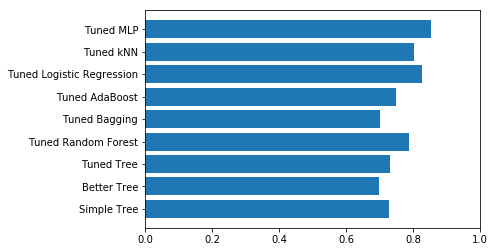

In [51]:
plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.keys()))

In [52]:
display(model_valid_accuracy_comparisons)

{'AdaBoost': 0.5675,
 'Bagging': 0.7416666666666667,
 'Better Tree': 0.69166666666666665,
 'Logistic Regression': 0.8175,
 'MLP': 0.82750000000000001,
 'Random Forest': 0.77583333333333337,
 'Simple Tree': 0.71666666666666667,
 'kNN': 0.78000000000000003}

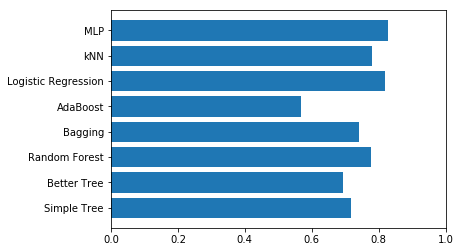

In [53]:
plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_valid_accuracy_comparisons)), list(model_valid_accuracy_comparisons.values()), align='center')
_= plt.yticks(range(len(model_valid_accuracy_comparisons)), list(model_valid_accuracy_comparisons.keys()))

In [54]:
display(model_tuned_params_list)

{'Tuned AdaBoost': {'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=200,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              presort=False, random_state=None, splitter='best'),
  'n_estimators': 400},
 'Tuned Bagging': {'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=200,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              presort=False, random_state=None, splitter='best'),
  'n_estimators': 350},
 'Tuned Logistic Regression': {'C': 0.6,
  'max_iter': 1000,
  'multi_class': 'ovr',
  'solver': 'liblinear'},
 'Tuned MLP': {'alpha': 0.001, 'hidden_layer_sizes': (400, 200)},
 'Tuned Random Forest': {'max_features': 6,
  'min_sam

### Test Best Model On Test Dataset

In [55]:
test_dataset = pd.read_csv('fashion-mnist_test.csv')
test_dataset.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
test_X = test_dataset[test_dataset.columns[1:]]
test_Y = np.array(test_dataset["label"])

In [57]:
test_X = test_X/255

In [58]:
my_model = linear_model.LogisticRegression(C=0.4,max_iter = 1000,multi_class='ovr',solver='liblinear')
my_model = my_model.fit(X,Y)

In [59]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(test_X)

# Print performance details
accuracy = metrics.accuracy_score(test_Y, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(test_Y, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(test_Y), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8499
             precision    recall  f1-score   support

          0       0.81      0.79      0.80      1000
          1       0.98      0.96      0.97      1000
          2       0.82      0.71      0.76      1000
          3       0.78      0.92      0.85      1000
          4       0.76      0.78      0.77      1000
          5       0.93      0.91      0.92      1000
          6       0.65      0.66      0.65      1000
          7       0.89      0.92      0.91      1000
          8       0.98      0.91      0.95      1000
          9       0.93      0.94      0.94      1000

avg / total       0.85      0.85      0.85     10000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,793,5,6,69,3,2,118,0,4,0,1000
1,1,960,4,29,0,1,5,0,0,0,1000
2,20,1,709,29,143,2,92,0,4,0,1000
3,23,12,7,921,18,0,19,0,0,0,1000
4,0,1,66,64,779,0,89,0,1,0,1000
5,2,0,0,1,0,912,1,55,3,26,1000
6,137,2,66,55,80,0,655,0,5,0,1000
7,0,0,0,0,0,44,0,917,0,39,1000
8,8,0,11,11,7,8,35,6,913,1,1000
